### Inference notebook:
- https://www.kaggle.com/code/ravaghi/skin-cancer-detection-resnet50-inference

# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import pandas as pd
import numpy as np
import warnings
import h5py
import torch
import random
import timm
import cv2
import io
import os
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_metadata_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
    test_metadata_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv'
    train_img_path = '/kaggle/input/isic-2024-challenge/train-image.hdf5'
    test_img_path = '/kaggle/input/isic-2024-challenge/test-image.hdf5'
    sample_sub_path = '/kaggle/input/isic-2024-challenge/sample_submission.csv'
    checkpoint_path = '/kaggle/working/checkpoints'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image_size = 224
    max_epochs = 100
    learning_rate = 5e-4
    weight_decay = 1e-6
    min_lr = 1e-6
    train_batch_size = 32
    val_batch_size = 64
    n_folds = 5
    seed = 35555
    model_name = "resnet50"
    es_patience = 15

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG.seed)

# Loading and splitting the datasets

In [4]:
train_metadata = pd.read_csv(CFG.train_metadata_path)

positives = train_metadata[train_metadata.target == 1]
negatives = train_metadata[train_metadata.target == 0]
train_metadata = pd.concat([positives, negatives.sample(n=20 * len(positives), random_state=CFG.seed)])
train_metadata = train_metadata.sample(frac=1, random_state=CFG.seed).reset_index(drop=True)

In [5]:
sgkf = StratifiedGroupKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = sgkf.split(train_metadata, train_metadata.target, groups=train_metadata.patient_id)
for i, (_, val_index) in enumerate(split):
    train_metadata.loc[val_index, 'fold'] = i

In [6]:
train_metadata2 = pd.read_csv(CFG.train_metadata_path)

sgkf = StratifiedGroupKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = sgkf.split(train_metadata2, train_metadata2.target, groups=train_metadata2.patient_id)
for i, (_, val_index) in enumerate(split):
    train_metadata2.loc[val_index, 'fold'] = i

In [7]:
CFG.t_max = train_metadata.shape[0] * (CFG.n_folds-1) * CFG.max_epochs // CFG.train_batch_size // CFG.n_folds

# Creating a custom image dataset

In [8]:
class ISICDataset(Dataset):
    def __init__(self, data_path, metadata, transform=None):
        self.data = h5py.File(data_path, 'r')
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = self.metadata.iloc[idx]['isic_id']
        image = np.array(self.data[img_name])
        image = np.array(Image.open(io.BytesIO(image)))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if 'target' in self.metadata.columns:
            label = int(self.metadata['target'].iloc[idx])
            return image, label
        else:
            return image, 0

In [9]:
transforms = {
    'train': A.Compose([
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.OneOf([
            A.HueSaturationValue(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
        ], p=0.5),
        A.OneOf([
            A.GaussNoise(p=0.5),
            A.GaussianBlur(p=0.5),
            A.MotionBlur(p=0.5),
        ], p=0.5),
        A.Resize(CFG.image_size, CFG.image_size),
        A.Normalize(
            mean=[0.4815, 0.4578, 0.4082],
            std=[0.2686, 0.2613, 0.2758],
            max_pixel_value=255.0),
        ToTensorV2(),
    ]),

    'val': A.Compose([
        A.Resize(CFG.image_size, CFG.image_size),
        A.Normalize(
            mean=[0.4815, 0.4578, 0.4082],
            std=[0.2686, 0.2613, 0.2758],
            max_pixel_value=255.0),
        ToTensorV2(),
    ])
}

# Customizing the image model

In [10]:
class ResNet(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super(ResNet, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        num_features = 1000
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x

# Creating a trainer class

In [11]:
class Trainer:
    def __init__(
        self,
        device,
        model,
        criterion,
        optimizer,
        scheduler,
        train_dataloader,
        val_dataloader,
        checkpoint_path,
        fold_idx,
        es_patience
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_pauc = 0.0
        self.best_model_path = None
        self.fold_idx = fold_idx
        self.es_patience = es_patience
        self.create_checkpoint_path()

    def create_checkpoint_path(self):
        if not os.path.exists(self.checkpoint_path):
            os.makedirs(self.checkpoint_path)

    @staticmethod
    def p_roc_auc_score(y_true, y_preds, min_tpr: float = 0.80):
        v_gt = abs(np.asarray(y_true)-1)
        v_pred = -1.0 * np.asarray(y_preds)
        max_fpr = abs(1-min_tpr)
        fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
        if max_fpr is None or max_fpr == 1:
            return auc(fpr, tpr)
        if max_fpr <= 0 or max_fpr > 1:
            raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        stop = np.searchsorted(fpr, max_fpr, "right")
        x_interp = [fpr[stop - 1], fpr[stop]]
        y_interp = [tpr[stop - 1], tpr[stop]]
        tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
        fpr = np.append(fpr[:stop], max_fpr)
        partial_auc = auc(fpr, tpr)
        return partial_auc

    def train(self, current_epoch_nr):
        self.model.train()

        num_batches = len(self.train_dataloader)

        running_loss = 0.0
        total = 0

        preds = []
        targets = []

        loop = tqdm(self.train_dataloader, total=num_batches)
        for batch in loop:
            x, y = batch
            x, y = x.to(self.device, dtype=torch.float), y.to(self.device, dtype=torch.float)

            self.optimizer.zero_grad()

            y_hat = self.model(x).squeeze()

            preds.extend(y_hat.detach().cpu().numpy())
            targets.extend(y.detach().cpu().numpy())

            loss = self.criterion(y_hat, y)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            total += y.size(0)

            loop.set_description(f'Epoch {current_epoch_nr}')
            loop.set_postfix(train_loss=round(running_loss / total, 6))

            if self.scheduler is not None:
                self.scheduler.step()

        train_pauc = self.p_roc_auc_score(targets, preds)
        train_loss = running_loss / num_batches

        return train_pauc, train_loss

    def evaluate(self, current_epoch_nr):
        self.model.eval()

        num_batches = len(self.val_dataloader)

        running_loss = 0.0
        total = 0

        preds = []
        targets = []

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device, dtype=torch.float), y.to(self.device, dtype=torch.float)

                self.optimizer.zero_grad()

                y_hat = self.model(x).squeeze()
                
                preds.extend(y_hat.detach().cpu().numpy())
                targets.extend(y.detach().cpu().numpy())

                loss = self.criterion(y_hat, y)
                running_loss += loss.item() * x.size(0)
                total += y.size(0)

                loop.set_description(f'Epoch {current_epoch_nr}')
                loop.set_postfix(val_loss=round(running_loss / total, 6))

        val_pauc = self.p_roc_auc_score(targets, preds)
        val_loss = running_loss / num_batches

        if val_pauc > self.best_pauc:
            self.es_patience = CFG.es_patience
            if self.best_pauc != 0.0:
                print(f'New best model found: pAUC = {val_pauc:.6f} (previous best: {self.best_pauc:.6f})')
            self.best_pauc = val_pauc
            checkpoint_name = f'fold_{self.fold_idx}_epoch_{current_epoch_nr}_pauc_{round(val_pauc, 6)}.pth'

            for file in os.listdir(self.checkpoint_path):
                if file.startswith(f'fold_{self.fold_idx}_epoch_'):
                    os.remove(os.path.join(self.checkpoint_path, file))

            torch.save(
                self.model.state_dict(),
                os.path.join(self.checkpoint_path, checkpoint_name)
            )
            self.best_model_path = os.path.join(
                self.checkpoint_path, checkpoint_name)

        else:
            self.es_patience -= 1
            if self.es_patience == 0:
                print(f'Early stopping triggered at epoch {current_epoch_nr}. Best pAUC = {self.best_pauc:.6f}')
                return val_pauc, val_loss, True

        return val_pauc, val_loss, False

    def predict(self, dataloader):
        model = self.model.to(self.device)
        model.load_state_dict(torch.load(self.best_model_path))
        model.eval()

        preds = []
        with torch.no_grad():
            loop = tqdm(dataloader, total=len(dataloader))
            for batch in loop:
                x, _ = batch
                x = x.to(self.device, dtype=torch.float)
                y_hat = model(x).squeeze()
                preds.extend(y_hat.detach().cpu().numpy())
                loop.set_description(f'Prediction')

        return preds

# Training and cross-validation

In [12]:
histories = {}
oof_pred_probs_df = []

for fold_idx in range(CFG.n_folds):
    print(f'---------------------------------- Fold {fold_idx + 1} ----------------------------------')

    _train = train_metadata[train_metadata['fold'] != fold_idx]
    train_dataset = ISICDataset(CFG.train_img_path, _train, transforms['train'])
    train_dataloader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, shuffle=True,  num_workers=4)

    _val = train_metadata[train_metadata['fold'] == fold_idx]
    val_dataset = ISICDataset(CFG.train_img_path, _val, transforms['val'])
    val_dataloader = DataLoader(val_dataset, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4)

    _val2 = train_metadata2[train_metadata2['fold'] == fold_idx]
    val_dataset2 = ISICDataset(CFG.train_img_path, _val2, transforms['val'])
    val_dataloader2 = DataLoader(val_dataset2, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4)

    model = ResNet(CFG.model_name).to(CFG.device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.t_max, eta_min=CFG.min_lr)

    trainer = Trainer(
        device=CFG.device,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        checkpoint_path=CFG.checkpoint_path,
        fold_idx=fold_idx,
        es_patience=CFG.es_patience
    )

    history = {
        'epoch': [],
        'train_pauc': [],
        'train_loss': [],
        'val_pauc': [],
        'val_loss': []
    }
    for epoch in range(1, CFG.max_epochs + 1):
        train_pauc, train_loss = trainer.train(current_epoch_nr=epoch)
        val_pauc, val_loss, es_triggered = trainer.evaluate(current_epoch_nr=epoch)

        print(f"Epoch {epoch}: Train pAUC: {train_pauc:.6f} - Val pAUC: {val_pauc:.6f} | Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}\n")

        history['epoch'].append(epoch)
        history['train_pauc'].append(train_pauc)
        history['train_loss'].append(train_loss)
        history['val_pauc'].append(val_pauc)
        history['val_loss'].append(val_loss)

        if es_triggered:
            break

    histories[f'Fold {fold_idx + 1}'] = history

    pred_probs = trainer.predict(val_dataloader2)
    _val2[CFG.model_name] = pred_probs
    oof_pred_probs_df.append(_val2)

    del _train, _val, train_dataset, val_dataset, model, criterion, optimizer, scheduler, trainer
    gc.collect()
    torch.cuda.empty_cache()

    print(f'---------------------------------- Fold {fold_idx + 1} ----------------------------------\n\n')

---------------------------------- Fold 1 ----------------------------------


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 25/25 [00:03<00:00,  6.71it/s, val_loss=0.151]


Epoch 1: Train pAUC: 0.051812 - Val pAUC: 0.061770 | Train Loss: 7.072705 - Val Loss: 9.628714



Epoch 2: 100%|██████████| 25/25 [00:03<00:00,  7.36it/s, val_loss=0.145]


New best model found: pAUC = 0.099511 (previous best: 0.061770)
Epoch 2: Train pAUC: 0.080981 - Val pAUC: 0.099511 | Train Loss: 5.300417 - Val Loss: 9.218716



Epoch 3: 100%|██████████| 25/25 [00:03<00:00,  7.16it/s, val_loss=0.137]


New best model found: pAUC = 0.101851 (previous best: 0.099511)
Epoch 3: Train pAUC: 0.098104 - Val pAUC: 0.101851 | Train Loss: 4.959954 - Val Loss: 8.704678



Epoch 4: 100%|██████████| 25/25 [00:03<00:00,  7.30it/s, val_loss=0.122]


New best model found: pAUC = 0.112383 (previous best: 0.101851)
Epoch 4: Train pAUC: 0.094199 - Val pAUC: 0.112383 | Train Loss: 4.856074 - Val Loss: 7.782387



Epoch 5: 100%|██████████| 25/25 [00:03<00:00,  7.33it/s, val_loss=0.122]


New best model found: pAUC = 0.114260 (previous best: 0.112383)
Epoch 5: Train pAUC: 0.106983 - Val pAUC: 0.114260 | Train Loss: 4.420383 - Val Loss: 7.758001



Epoch 6: 100%|██████████| 25/25 [00:03<00:00,  7.15it/s, val_loss=0.122]


New best model found: pAUC = 0.128837 (previous best: 0.114260)
Epoch 6: Train pAUC: 0.108219 - Val pAUC: 0.128837 | Train Loss: 4.495279 - Val Loss: 7.750842



Epoch 7: 100%|██████████| 25/25 [00:03<00:00,  7.32it/s, val_loss=0.116]


Epoch 7: Train pAUC: 0.124005 - Val pAUC: 0.124388 | Train Loss: 4.326774 - Val Loss: 7.392895



Epoch 8: 100%|██████████| 25/25 [00:03<00:00,  7.41it/s, val_loss=0.123]


Epoch 8: Train pAUC: 0.131941 - Val pAUC: 0.117660 | Train Loss: 4.215705 - Val Loss: 7.804639



Epoch 9: 100%|██████████| 25/25 [00:03<00:00,  6.95it/s, val_loss=0.118]


New best model found: pAUC = 0.132409 (previous best: 0.128837)
Epoch 9: Train pAUC: 0.115672 - Val pAUC: 0.132409 | Train Loss: 4.261281 - Val Loss: 7.533880



Epoch 10: 100%|██████████| 25/25 [00:03<00:00,  7.35it/s, val_loss=0.142]


Epoch 10: Train pAUC: 0.127400 - Val pAUC: 0.119778 | Train Loss: 4.176535 - Val Loss: 9.012150



Epoch 11: 100%|██████████| 25/25 [00:03<00:00,  7.11it/s, val_loss=0.122]


Epoch 11: Train pAUC: 0.129288 - Val pAUC: 0.127778 | Train Loss: 3.978659 - Val Loss: 7.759785



Epoch 12: 100%|██████████| 25/25 [00:03<00:00,  7.23it/s, val_loss=0.143]


Epoch 12: Train pAUC: 0.136731 - Val pAUC: 0.128141 | Train Loss: 3.855312 - Val Loss: 9.102569



Epoch 13: 100%|██████████| 25/25 [00:03<00:00,  7.37it/s, val_loss=0.122]


Epoch 13: Train pAUC: 0.128858 - Val pAUC: 0.108883 | Train Loss: 3.981350 - Val Loss: 7.746649



Epoch 14: 100%|██████████| 25/25 [00:03<00:00,  7.34it/s, val_loss=0.113]


New best model found: pAUC = 0.133801 (previous best: 0.132409)
Epoch 14: Train pAUC: 0.141774 - Val pAUC: 0.133801 | Train Loss: 3.771945 - Val Loss: 7.216801



Epoch 15: 100%|██████████| 25/25 [00:03<00:00,  7.35it/s, val_loss=0.113]


New best model found: pAUC = 0.149478 (previous best: 0.133801)
Epoch 15: Train pAUC: 0.145487 - Val pAUC: 0.149478 | Train Loss: 3.818867 - Val Loss: 7.214452



Epoch 16: 100%|██████████| 25/25 [00:03<00:00,  7.33it/s, val_loss=0.114]


Epoch 16: Train pAUC: 0.140854 - Val pAUC: 0.142910 | Train Loss: 3.758980 - Val Loss: 7.279975



Epoch 17: 100%|██████████| 25/25 [00:03<00:00,  7.30it/s, val_loss=0.12]


Epoch 17: Train pAUC: 0.136795 - Val pAUC: 0.137574 | Train Loss: 3.803948 - Val Loss: 7.619934



Epoch 18: 100%|██████████| 25/25 [00:03<00:00,  7.32it/s, val_loss=0.115]


Epoch 18: Train pAUC: 0.138856 - Val pAUC: 0.143455 | Train Loss: 3.720408 - Val Loss: 7.318373



Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  7.33it/s, val_loss=0.119]


Epoch 19: Train pAUC: 0.142051 - Val pAUC: 0.147148 | Train Loss: 3.613674 - Val Loss: 7.558409



Epoch 20: 100%|██████████| 25/25 [00:03<00:00,  7.35it/s, val_loss=0.133]


Epoch 20: Train pAUC: 0.137803 - Val pAUC: 0.122522 | Train Loss: 3.705379 - Val Loss: 8.473498



Epoch 21: 100%|██████████| 25/25 [00:03<00:00,  7.29it/s, val_loss=0.126]


Epoch 21: Train pAUC: 0.149334 - Val pAUC: 0.127617 | Train Loss: 3.515864 - Val Loss: 8.028858



Epoch 22: 100%|██████████| 25/25 [00:03<00:00,  7.37it/s, val_loss=0.118]


Epoch 22: Train pAUC: 0.134904 - Val pAUC: 0.129513 | Train Loss: 3.796947 - Val Loss: 7.535414



Epoch 23: 100%|██████████| 25/25 [00:03<00:00,  7.33it/s, val_loss=0.126]


Epoch 23: Train pAUC: 0.150788 - Val pAUC: 0.132671 | Train Loss: 3.428735 - Val Loss: 7.994138



Epoch 24: 100%|██████████| 25/25 [00:03<00:00,  7.30it/s, val_loss=0.126]


Epoch 24: Train pAUC: 0.160203 - Val pAUC: 0.123289 | Train Loss: 3.214956 - Val Loss: 7.983300



Epoch 25: 100%|██████████| 25/25 [00:03<00:00,  7.35it/s, val_loss=0.116]


Epoch 25: Train pAUC: 0.155001 - Val pAUC: 0.139198 | Train Loss: 3.295279 - Val Loss: 7.369693



Epoch 26: 100%|██████████| 25/25 [00:03<00:00,  6.41it/s, val_loss=0.12]


New best model found: pAUC = 0.149801 (previous best: 0.149478)
Epoch 26: Train pAUC: 0.162944 - Val pAUC: 0.149801 | Train Loss: 3.172471 - Val Loss: 7.622853



Epoch 27: 100%|██████████| 25/25 [00:03<00:00,  7.32it/s, val_loss=0.12]


Epoch 27: Train pAUC: 0.159059 - Val pAUC: 0.138431 | Train Loss: 3.266369 - Val Loss: 7.616871



Epoch 28: 100%|██████████| 25/25 [00:03<00:00,  7.15it/s, val_loss=0.112]


Epoch 28: Train pAUC: 0.158951 - Val pAUC: 0.138714 | Train Loss: 3.224449 - Val Loss: 7.136262



Epoch 29: 100%|██████████| 25/25 [00:03<00:00,  6.98it/s, val_loss=0.111]


Epoch 29: Train pAUC: 0.159847 - Val pAUC: 0.147208 | Train Loss: 3.132618 - Val Loss: 7.060250



Epoch 30: 100%|██████████| 25/25 [00:03<00:00,  6.88it/s, val_loss=0.115]


Epoch 30: Train pAUC: 0.159057 - Val pAUC: 0.120585 | Train Loss: 3.138554 - Val Loss: 7.284608



Epoch 31: 100%|██████████| 25/25 [00:03<00:00,  7.37it/s, val_loss=0.118]


Epoch 31: Train pAUC: 0.159912 - Val pAUC: 0.138916 | Train Loss: 3.079640 - Val Loss: 7.512456



Epoch 32: 100%|██████████| 25/25 [00:03<00:00,  7.32it/s, val_loss=0.138]


Epoch 32: Train pAUC: 0.165984 - Val pAUC: 0.138068 | Train Loss: 2.878654 - Val Loss: 8.760847



Epoch 33: 100%|██████████| 25/25 [00:03<00:00,  7.25it/s, val_loss=0.126]


Epoch 33: Train pAUC: 0.169315 - Val pAUC: 0.144131 | Train Loss: 2.817933 - Val Loss: 7.981814



Epoch 34: 100%|██████████| 25/25 [00:03<00:00,  7.38it/s, val_loss=0.136]


Epoch 34: Train pAUC: 0.164861 - Val pAUC: 0.134456 | Train Loss: 2.899639 - Val Loss: 8.634681



Epoch 35: 100%|██████████| 25/25 [00:03<00:00,  6.92it/s, val_loss=0.126]


Epoch 35: Train pAUC: 0.169041 - Val pAUC: 0.144968 | Train Loss: 2.838697 - Val Loss: 8.017243



Epoch 36: 100%|██████████| 25/25 [00:03<00:00,  7.30it/s, val_loss=0.133]


Epoch 36: Train pAUC: 0.171809 - Val pAUC: 0.140328 | Train Loss: 2.651797 - Val Loss: 8.474770



Epoch 37: 100%|██████████| 25/25 [00:03<00:00,  7.39it/s, val_loss=0.12]


Epoch 37: Train pAUC: 0.173907 - Val pAUC: 0.131733 | Train Loss: 2.652354 - Val Loss: 7.602399



Epoch 38: 100%|██████████| 25/25 [00:03<00:00,  7.32it/s, val_loss=0.111]


Epoch 38: Train pAUC: 0.170779 - Val pAUC: 0.135334 | Train Loss: 2.618561 - Val Loss: 7.035163



Epoch 39: 100%|██████████| 25/25 [00:03<00:00,  7.32it/s, val_loss=0.128]


Epoch 39: Train pAUC: 0.179467 - Val pAUC: 0.143778 | Train Loss: 2.339521 - Val Loss: 8.142588



Epoch 40: 100%|██████████| 25/25 [00:03<00:00,  7.18it/s, val_loss=0.124]


Epoch 40: Train pAUC: 0.177764 - Val pAUC: 0.145362 | Train Loss: 2.336487 - Val Loss: 7.913398



Epoch 41: 100%|██████████| 25/25 [00:03<00:00,  7.30it/s, val_loss=0.136]


Early stopping triggered at epoch 41. Best pAUC = 0.149801
Epoch 41: Train pAUC: 0.180005 - Val pAUC: 0.141801 | Train Loss: 2.278969 - Val Loss: 8.650189



Prediction: 100%|██████████| 1211/1211 [02:19<00:00,  8.71it/s]


---------------------------------- Fold 1 ----------------------------------


---------------------------------- Fold 2 ----------------------------------


Epoch 1: 100%|██████████| 29/29 [00:03<00:00,  7.52it/s, val_loss=0.143]


Epoch 1: Train pAUC: 0.034142 - Val pAUC: 0.076890 | Train Loss: 7.479569 - Val Loss: 9.004036



Epoch 2: 100%|██████████| 29/29 [00:03<00:00,  7.52it/s, val_loss=0.135]


New best model found: pAUC = 0.082500 (previous best: 0.076890)
Epoch 2: Train pAUC: 0.066986 - Val pAUC: 0.082500 | Train Loss: 5.568219 - Val Loss: 8.488283



Epoch 3: 100%|██████████| 29/29 [00:03<00:00,  7.49it/s, val_loss=0.126]


New best model found: pAUC = 0.106564 (previous best: 0.082500)
Epoch 3: Train pAUC: 0.079469 - Val pAUC: 0.106564 | Train Loss: 5.338510 - Val Loss: 7.969644



Epoch 4: 100%|██████████| 29/29 [00:03<00:00,  7.45it/s, val_loss=0.111]


Epoch 4: Train pAUC: 0.103101 - Val pAUC: 0.103114 | Train Loss: 4.776442 - Val Loss: 7.011851



Epoch 5: 100%|██████████| 29/29 [00:03<00:00,  7.50it/s, val_loss=0.111]


New best model found: pAUC = 0.112486 (previous best: 0.106564)
Epoch 5: Train pAUC: 0.100515 - Val pAUC: 0.112486 | Train Loss: 4.842001 - Val Loss: 7.007884



Epoch 6: 100%|██████████| 29/29 [00:04<00:00,  7.16it/s, val_loss=0.1]


New best model found: pAUC = 0.131613 (previous best: 0.112486)
Epoch 6: Train pAUC: 0.101446 - Val pAUC: 0.131613 | Train Loss: 4.585205 - Val Loss: 6.319854



Epoch 7: 100%|██████████| 29/29 [00:04<00:00,  7.08it/s, val_loss=0.108]


Epoch 7: Train pAUC: 0.108069 - Val pAUC: 0.114158 | Train Loss: 4.577962 - Val Loss: 6.789950



Epoch 8: 100%|██████████| 29/29 [00:03<00:00,  7.45it/s, val_loss=0.103]


Epoch 8: Train pAUC: 0.118982 - Val pAUC: 0.116601 | Train Loss: 4.367958 - Val Loss: 6.511096



Epoch 9: 100%|██████████| 29/29 [00:03<00:00,  7.34it/s, val_loss=0.0946]


New best model found: pAUC = 0.140923 (previous best: 0.131613)
Epoch 9: Train pAUC: 0.129822 - Val pAUC: 0.140923 | Train Loss: 4.071737 - Val Loss: 5.961751



Epoch 10: 100%|██████████| 29/29 [00:03<00:00,  7.44it/s, val_loss=0.106]


Epoch 10: Train pAUC: 0.122128 - Val pAUC: 0.136154 | Train Loss: 4.358959 - Val Loss: 6.698001



Epoch 11: 100%|██████████| 29/29 [00:04<00:00,  7.16it/s, val_loss=0.0987]


Epoch 11: Train pAUC: 0.124467 - Val pAUC: 0.130480 | Train Loss: 4.237566 - Val Loss: 6.218885



Epoch 12: 100%|██████████| 29/29 [00:03<00:00,  7.42it/s, val_loss=0.103]


Epoch 12: Train pAUC: 0.141180 - Val pAUC: 0.128368 | Train Loss: 3.993906 - Val Loss: 6.491967



Epoch 13: 100%|██████████| 29/29 [00:03<00:00,  7.50it/s, val_loss=0.0976]


Epoch 13: Train pAUC: 0.133516 - Val pAUC: 0.130913 | Train Loss: 4.076782 - Val Loss: 6.153252



Epoch 14: 100%|██████████| 29/29 [00:03<00:00,  7.49it/s, val_loss=0.106]


Epoch 14: Train pAUC: 0.141155 - Val pAUC: 0.120663 | Train Loss: 3.896497 - Val Loss: 6.669553



Epoch 15: 100%|██████████| 29/29 [00:03<00:00,  7.48it/s, val_loss=0.1]


Epoch 15: Train pAUC: 0.142618 - Val pAUC: 0.134613 | Train Loss: 3.934977 - Val Loss: 6.308443



Epoch 16: 100%|██████████| 29/29 [00:03<00:00,  7.46it/s, val_loss=0.106]


Epoch 16: Train pAUC: 0.144881 - Val pAUC: 0.126730 | Train Loss: 3.837484 - Val Loss: 6.662074



Epoch 17: 100%|██████████| 29/29 [00:03<00:00,  7.29it/s, val_loss=0.102]


Epoch 17: Train pAUC: 0.145813 - Val pAUC: 0.122375 | Train Loss: 3.877272 - Val Loss: 6.432013



Epoch 18: 100%|██████████| 29/29 [00:03<00:00,  7.55it/s, val_loss=0.0943]


Epoch 18: Train pAUC: 0.153084 - Val pAUC: 0.136466 | Train Loss: 3.641127 - Val Loss: 5.945629



Epoch 19: 100%|██████████| 29/29 [00:03<00:00,  7.47it/s, val_loss=0.0968]


Epoch 19: Train pAUC: 0.150487 - Val pAUC: 0.129525 | Train Loss: 3.761310 - Val Loss: 6.104184



Epoch 20: 100%|██████████| 29/29 [00:03<00:00,  7.43it/s, val_loss=0.0945]


Epoch 20: Train pAUC: 0.147400 - Val pAUC: 0.135839 | Train Loss: 3.730030 - Val Loss: 5.958096



Epoch 21: 100%|██████████| 29/29 [00:03<00:00,  7.49it/s, val_loss=0.0964]


New best model found: pAUC = 0.144550 (previous best: 0.140923)
Epoch 21: Train pAUC: 0.137907 - Val pAUC: 0.144550 | Train Loss: 3.945995 - Val Loss: 6.078517



Epoch 22: 100%|██████████| 29/29 [00:03<00:00,  7.48it/s, val_loss=0.0926]


New best model found: pAUC = 0.145118 (previous best: 0.144550)
Epoch 22: Train pAUC: 0.149167 - Val pAUC: 0.145118 | Train Loss: 3.673664 - Val Loss: 5.835938



Epoch 23: 100%|██████████| 29/29 [00:04<00:00,  7.23it/s, val_loss=0.0954]


Epoch 23: Train pAUC: 0.167194 - Val pAUC: 0.135530 | Train Loss: 3.244030 - Val Loss: 6.010786



Epoch 24: 100%|██████████| 29/29 [00:03<00:00,  7.56it/s, val_loss=0.104]


New best model found: pAUC = 0.145817 (previous best: 0.145118)
Epoch 24: Train pAUC: 0.155931 - Val pAUC: 0.145817 | Train Loss: 3.411078 - Val Loss: 6.578479



Epoch 25: 100%|██████████| 29/29 [00:04<00:00,  7.23it/s, val_loss=0.103]


Epoch 25: Train pAUC: 0.164230 - Val pAUC: 0.120924 | Train Loss: 3.219125 - Val Loss: 6.491374



Epoch 26: 100%|██████████| 29/29 [00:03<00:00,  7.57it/s, val_loss=0.101]


Epoch 26: Train pAUC: 0.162146 - Val pAUC: 0.138017 | Train Loss: 3.271646 - Val Loss: 6.365648



Epoch 27: 100%|██████████| 29/29 [00:03<00:00,  7.59it/s, val_loss=0.106]


Epoch 27: Train pAUC: 0.164162 - Val pAUC: 0.128078 | Train Loss: 3.131839 - Val Loss: 6.653654



Epoch 28: 100%|██████████| 29/29 [00:03<00:00,  7.38it/s, val_loss=0.103]


Epoch 28: Train pAUC: 0.166384 - Val pAUC: 0.145545 | Train Loss: 3.163274 - Val Loss: 6.484281



Epoch 29: 100%|██████████| 29/29 [00:03<00:00,  7.54it/s, val_loss=0.104]


Epoch 29: Train pAUC: 0.163532 - Val pAUC: 0.133069 | Train Loss: 3.078089 - Val Loss: 6.580256



Epoch 30: 100%|██████████| 29/29 [00:03<00:00,  7.51it/s, val_loss=0.102]


Epoch 30: Train pAUC: 0.163913 - Val pAUC: 0.131220 | Train Loss: 3.081218 - Val Loss: 6.416140



Epoch 31: 100%|██████████| 29/29 [00:03<00:00,  7.48it/s, val_loss=0.109]


Epoch 31: Train pAUC: 0.166722 - Val pAUC: 0.139012 | Train Loss: 2.974363 - Val Loss: 6.878360



Epoch 32: 100%|██████████| 29/29 [00:03<00:00,  7.60it/s, val_loss=0.0993]


Epoch 32: Train pAUC: 0.170210 - Val pAUC: 0.145297 | Train Loss: 2.967473 - Val Loss: 6.260018



Epoch 33: 100%|██████████| 29/29 [00:03<00:00,  7.55it/s, val_loss=0.0958]


Epoch 33: Train pAUC: 0.172011 - Val pAUC: 0.143118 | Train Loss: 2.845446 - Val Loss: 6.036667



Epoch 34: 100%|██████████| 29/29 [00:03<00:00,  7.61it/s, val_loss=0.0976]


New best model found: pAUC = 0.151643 (previous best: 0.145817)
Epoch 34: Train pAUC: 0.166804 - Val pAUC: 0.151643 | Train Loss: 2.918387 - Val Loss: 6.153280



Epoch 35: 100%|██████████| 29/29 [00:03<00:00,  7.66it/s, val_loss=0.099]


Epoch 35: Train pAUC: 0.171615 - Val pAUC: 0.147698 | Train Loss: 2.884280 - Val Loss: 6.238078



Epoch 36: 100%|██████████| 29/29 [00:03<00:00,  7.61it/s, val_loss=0.0954]


Epoch 36: Train pAUC: 0.165531 - Val pAUC: 0.129677 | Train Loss: 2.846500 - Val Loss: 6.013895



Epoch 37: 100%|██████████| 29/29 [00:03<00:00,  7.54it/s, val_loss=0.117]


Epoch 37: Train pAUC: 0.175352 - Val pAUC: 0.147530 | Train Loss: 2.518604 - Val Loss: 7.344112



Epoch 38: 100%|██████████| 29/29 [00:03<00:00,  7.66it/s, val_loss=0.114]


Epoch 38: Train pAUC: 0.169851 - Val pAUC: 0.144776 | Train Loss: 2.642542 - Val Loss: 7.194007



Epoch 39: 100%|██████████| 29/29 [00:03<00:00,  7.62it/s, val_loss=0.0976]


Epoch 39: Train pAUC: 0.177741 - Val pAUC: 0.142601 | Train Loss: 2.451594 - Val Loss: 6.153074



Epoch 40: 100%|██████████| 29/29 [00:03<00:00,  7.46it/s, val_loss=0.114]


Epoch 40: Train pAUC: 0.178694 - Val pAUC: 0.134075 | Train Loss: 2.391080 - Val Loss: 7.165620



Epoch 41: 100%|██████████| 29/29 [00:03<00:00,  7.54it/s, val_loss=0.114]


Epoch 41: Train pAUC: 0.178957 - Val pAUC: 0.126520 | Train Loss: 2.304590 - Val Loss: 7.172156



Epoch 42: 100%|██████████| 29/29 [00:03<00:00,  7.60it/s, val_loss=0.0967]


Epoch 42: Train pAUC: 0.176742 - Val pAUC: 0.146490 | Train Loss: 2.296929 - Val Loss: 6.092960



Epoch 43: 100%|██████████| 29/29 [00:03<00:00,  7.59it/s, val_loss=0.123]


Epoch 43: Train pAUC: 0.182244 - Val pAUC: 0.150946 | Train Loss: 2.171543 - Val Loss: 7.735447



Epoch 44: 100%|██████████| 29/29 [00:03<00:00,  7.39it/s, val_loss=0.11]


Epoch 44: Train pAUC: 0.179559 - Val pAUC: 0.132502 | Train Loss: 2.288330 - Val Loss: 6.924960



Epoch 45: 100%|██████████| 29/29 [00:03<00:00,  7.53it/s, val_loss=0.11]


Epoch 45: Train pAUC: 0.184960 - Val pAUC: 0.135263 | Train Loss: 1.951115 - Val Loss: 6.956969



Epoch 46: 100%|██████████| 29/29 [00:03<00:00,  7.66it/s, val_loss=0.118]


Epoch 46: Train pAUC: 0.188647 - Val pAUC: 0.136516 | Train Loss: 1.710247 - Val Loss: 7.435348



Epoch 47: 100%|██████████| 29/29 [00:03<00:00,  7.30it/s, val_loss=0.116]


Epoch 47: Train pAUC: 0.186757 - Val pAUC: 0.142582 | Train Loss: 1.909397 - Val Loss: 7.308315



Epoch 48: 100%|██████████| 29/29 [00:03<00:00,  7.59it/s, val_loss=0.126]


Epoch 48: Train pAUC: 0.187528 - Val pAUC: 0.136228 | Train Loss: 1.843139 - Val Loss: 7.970121



Epoch 49: 100%|██████████| 29/29 [00:03<00:00,  7.55it/s, val_loss=0.122]


Early stopping triggered at epoch 49. Best pAUC = 0.151643
Epoch 49: Train pAUC: 0.186555 - Val pAUC: 0.148635 | Train Loss: 1.864654 - Val Loss: 7.711548



Prediction: 100%|██████████| 1310/1310 [02:31<00:00,  8.65it/s]


---------------------------------- Fold 2 ----------------------------------


---------------------------------- Fold 3 ----------------------------------


Epoch 1: 100%|██████████| 21/21 [00:03<00:00,  6.91it/s, val_loss=0.234]


Epoch 1: Train pAUC: 0.044725 - Val pAUC: 0.063940 | Train Loss: 7.051363 - Val Loss: 14.540475



Epoch 2: 100%|██████████| 21/21 [00:02<00:00,  7.25it/s, val_loss=0.15]


New best model found: pAUC = 0.120201 (previous best: 0.063940)
Epoch 2: Train pAUC: 0.076938 - Val pAUC: 0.120201 | Train Loss: 5.270506 - Val Loss: 9.348022



Epoch 3: 100%|██████████| 21/21 [00:02<00:00,  7.25it/s, val_loss=0.171]


Epoch 3: Train pAUC: 0.072069 - Val pAUC: 0.111989 | Train Loss: 5.033764 - Val Loss: 10.612620



Epoch 4: 100%|██████████| 21/21 [00:02<00:00,  7.34it/s, val_loss=0.142]


New best model found: pAUC = 0.135319 (previous best: 0.120201)
Epoch 4: Train pAUC: 0.098212 - Val pAUC: 0.135319 | Train Loss: 4.719166 - Val Loss: 8.831224



Epoch 5: 100%|██████████| 21/21 [00:02<00:00,  7.16it/s, val_loss=0.133]


New best model found: pAUC = 0.139997 (previous best: 0.135319)
Epoch 5: Train pAUC: 0.099069 - Val pAUC: 0.139997 | Train Loss: 4.511760 - Val Loss: 8.239992



Epoch 6: 100%|██████████| 21/21 [00:02<00:00,  7.24it/s, val_loss=0.153]


Epoch 6: Train pAUC: 0.105097 - Val pAUC: 0.111887 | Train Loss: 4.332327 - Val Loss: 9.483927



Epoch 7: 100%|██████████| 21/21 [00:02<00:00,  7.21it/s, val_loss=0.138]


Epoch 7: Train pAUC: 0.122095 - Val pAUC: 0.126427 | Train Loss: 4.178681 - Val Loss: 8.590719



Epoch 8: 100%|██████████| 21/21 [00:02<00:00,  7.29it/s, val_loss=0.135]


Epoch 8: Train pAUC: 0.117759 - Val pAUC: 0.106590 | Train Loss: 4.109474 - Val Loss: 8.407777



Epoch 9: 100%|██████████| 21/21 [00:03<00:00,  6.65it/s, val_loss=0.132]


Epoch 9: Train pAUC: 0.126459 - Val pAUC: 0.130376 | Train Loss: 3.943363 - Val Loss: 8.181703



Epoch 10: 100%|██████████| 21/21 [00:02<00:00,  7.15it/s, val_loss=0.142]


Epoch 10: Train pAUC: 0.134511 - Val pAUC: 0.122996 | Train Loss: 3.894672 - Val Loss: 8.849914



Epoch 11: 100%|██████████| 21/21 [00:02<00:00,  7.18it/s, val_loss=0.129]


Epoch 11: Train pAUC: 0.130450 - Val pAUC: 0.135884 | Train Loss: 3.848689 - Val Loss: 8.037980



Epoch 12: 100%|██████████| 21/21 [00:02<00:00,  7.24it/s, val_loss=0.127]


Epoch 12: Train pAUC: 0.134180 - Val pAUC: 0.136330 | Train Loss: 3.772451 - Val Loss: 7.911222



Epoch 13: 100%|██████████| 21/21 [00:02<00:00,  7.27it/s, val_loss=0.125]


New best model found: pAUC = 0.141793 (previous best: 0.139997)
Epoch 13: Train pAUC: 0.133005 - Val pAUC: 0.141793 | Train Loss: 3.831551 - Val Loss: 7.739020



Epoch 14: 100%|██████████| 21/21 [00:03<00:00,  6.92it/s, val_loss=0.126]


Epoch 14: Train pAUC: 0.140218 - Val pAUC: 0.135840 | Train Loss: 3.757281 - Val Loss: 7.809136



Epoch 15: 100%|██████████| 21/21 [00:02<00:00,  7.41it/s, val_loss=0.147]


Epoch 15: Train pAUC: 0.140826 - Val pAUC: 0.130687 | Train Loss: 3.616747 - Val Loss: 9.165008



Epoch 16: 100%|██████████| 21/21 [00:03<00:00,  6.93it/s, val_loss=0.14]


Epoch 16: Train pAUC: 0.150654 - Val pAUC: 0.139691 | Train Loss: 3.509010 - Val Loss: 8.698652



Epoch 17: 100%|██████████| 21/21 [00:02<00:00,  7.32it/s, val_loss=0.129]


Epoch 17: Train pAUC: 0.142876 - Val pAUC: 0.122538 | Train Loss: 3.566582 - Val Loss: 8.035494



Epoch 18: 100%|██████████| 21/21 [00:02<00:00,  7.09it/s, val_loss=0.119]


New best model found: pAUC = 0.153466 (previous best: 0.141793)
Epoch 18: Train pAUC: 0.147752 - Val pAUC: 0.153466 | Train Loss: 3.502621 - Val Loss: 7.405103



Epoch 19: 100%|██████████| 21/21 [00:03<00:00,  6.98it/s, val_loss=0.126]


Epoch 19: Train pAUC: 0.139857 - Val pAUC: 0.127386 | Train Loss: 3.542284 - Val Loss: 7.800060



Epoch 20: 100%|██████████| 21/21 [00:02<00:00,  7.35it/s, val_loss=0.15]


Epoch 20: Train pAUC: 0.153105 - Val pAUC: 0.126043 | Train Loss: 3.338433 - Val Loss: 9.336368



Epoch 21: 100%|██████████| 21/21 [00:02<00:00,  7.22it/s, val_loss=0.122]


Epoch 21: Train pAUC: 0.147668 - Val pAUC: 0.129959 | Train Loss: 3.429498 - Val Loss: 7.582875



Epoch 22: 100%|██████████| 21/21 [00:02<00:00,  7.24it/s, val_loss=0.124]


Epoch 22: Train pAUC: 0.143989 - Val pAUC: 0.138124 | Train Loss: 3.458116 - Val Loss: 7.704023



Epoch 23: 100%|██████████| 21/21 [00:02<00:00,  7.34it/s, val_loss=0.122]


Epoch 23: Train pAUC: 0.158333 - Val pAUC: 0.145627 | Train Loss: 3.211961 - Val Loss: 7.584369



Epoch 24: 100%|██████████| 21/21 [00:02<00:00,  7.24it/s, val_loss=0.122]


Epoch 24: Train pAUC: 0.146325 - Val pAUC: 0.150949 | Train Loss: 3.421749 - Val Loss: 7.560263



Epoch 25: 100%|██████████| 21/21 [00:02<00:00,  7.28it/s, val_loss=0.12]


Epoch 25: Train pAUC: 0.156617 - Val pAUC: 0.138919 | Train Loss: 3.340546 - Val Loss: 7.447004



Epoch 26: 100%|██████████| 21/21 [00:02<00:00,  7.18it/s, val_loss=0.124]


Epoch 26: Train pAUC: 0.155792 - Val pAUC: 0.149454 | Train Loss: 3.265750 - Val Loss: 7.736547



Epoch 27: 100%|██████████| 21/21 [00:02<00:00,  7.24it/s, val_loss=0.116]


New best model found: pAUC = 0.158040 (previous best: 0.153466)
Epoch 27: Train pAUC: 0.155003 - Val pAUC: 0.158040 | Train Loss: 3.126269 - Val Loss: 7.230402



Epoch 28: 100%|██████████| 21/21 [00:02<00:00,  7.24it/s, val_loss=0.112]


New best model found: pAUC = 0.160078 (previous best: 0.158040)
Epoch 28: Train pAUC: 0.146803 - Val pAUC: 0.160078 | Train Loss: 3.270137 - Val Loss: 6.981712



Epoch 29: 100%|██████████| 21/21 [00:02<00:00,  7.26it/s, val_loss=0.127]


Epoch 29: Train pAUC: 0.162983 - Val pAUC: 0.139604 | Train Loss: 3.027910 - Val Loss: 7.889746



Epoch 30: 100%|██████████| 21/21 [00:03<00:00,  6.98it/s, val_loss=0.125]


Epoch 30: Train pAUC: 0.156450 - Val pAUC: 0.152408 | Train Loss: 3.089031 - Val Loss: 7.747543



Epoch 31: 100%|██████████| 21/21 [00:02<00:00,  7.04it/s, val_loss=0.125]


Epoch 31: Train pAUC: 0.139336 - Val pAUC: 0.145618 | Train Loss: 3.362710 - Val Loss: 7.789392



Epoch 32: 100%|██████████| 21/21 [00:02<00:00,  7.27it/s, val_loss=0.123]


Epoch 32: Train pAUC: 0.152342 - Val pAUC: 0.142220 | Train Loss: 3.041651 - Val Loss: 7.628401



Epoch 33: 100%|██████████| 21/21 [00:02<00:00,  7.32it/s, val_loss=0.119]


Epoch 33: Train pAUC: 0.160336 - Val pAUC: 0.154812 | Train Loss: 3.022483 - Val Loss: 7.391300



Epoch 34: 100%|██████████| 21/21 [00:02<00:00,  7.25it/s, val_loss=0.12]


Epoch 34: Train pAUC: 0.168579 - Val pAUC: 0.155554 | Train Loss: 2.801687 - Val Loss: 7.480127



Epoch 35: 100%|██████████| 21/21 [00:02<00:00,  7.33it/s, val_loss=0.131]


Epoch 35: Train pAUC: 0.166597 - Val pAUC: 0.149372 | Train Loss: 2.796372 - Val Loss: 8.130397



Epoch 36: 100%|██████████| 21/21 [00:02<00:00,  7.23it/s, val_loss=0.126]


Epoch 36: Train pAUC: 0.161010 - Val pAUC: 0.124778 | Train Loss: 2.725025 - Val Loss: 7.830634



Epoch 37: 100%|██████████| 21/21 [00:02<00:00,  7.31it/s, val_loss=0.128]


Epoch 37: Train pAUC: 0.178104 - Val pAUC: 0.131054 | Train Loss: 2.533540 - Val Loss: 7.955167



Epoch 38: 100%|██████████| 21/21 [00:02<00:00,  7.26it/s, val_loss=0.123]


Epoch 38: Train pAUC: 0.176628 - Val pAUC: 0.146599 | Train Loss: 2.484834 - Val Loss: 7.616971



Epoch 39: 100%|██████████| 21/21 [00:02<00:00,  7.34it/s, val_loss=0.116]


Epoch 39: Train pAUC: 0.176364 - Val pAUC: 0.150020 | Train Loss: 2.395009 - Val Loss: 7.239237



Epoch 40: 100%|██████████| 21/21 [00:02<00:00,  7.32it/s, val_loss=0.139]


Epoch 40: Train pAUC: 0.174417 - Val pAUC: 0.139185 | Train Loss: 2.471776 - Val Loss: 8.666135



Epoch 41: 100%|██████████| 21/21 [00:02<00:00,  7.29it/s, val_loss=0.117]


Epoch 41: Train pAUC: 0.169641 - Val pAUC: 0.155434 | Train Loss: 2.558451 - Val Loss: 7.274185



Epoch 42: 100%|██████████| 21/21 [00:02<00:00,  7.37it/s, val_loss=0.124]


Epoch 42: Train pAUC: 0.180120 - Val pAUC: 0.156955 | Train Loss: 2.274657 - Val Loss: 7.718105



Epoch 43: 100%|██████████| 21/21 [00:02<00:00,  7.30it/s, val_loss=0.14]


Early stopping triggered at epoch 43. Best pAUC = 0.160078
Epoch 43: Train pAUC: 0.175257 - Val pAUC: 0.157396 | Train Loss: 2.268782 - Val Loss: 8.695425



Prediction: 100%|██████████| 1191/1191 [02:17<00:00,  8.65it/s]


---------------------------------- Fold 3 ----------------------------------


---------------------------------- Fold 4 ----------------------------------


Epoch 1: 100%|██████████| 27/27 [00:03<00:00,  7.49it/s, val_loss=0.17]


Epoch 1: Train pAUC: 0.035674 - Val pAUC: 0.045616 | Train Loss: 7.432745 - Val Loss: 10.702635



Epoch 2: 100%|██████████| 27/27 [00:03<00:00,  7.44it/s, val_loss=0.157]


New best model found: pAUC = 0.063879 (previous best: 0.045616)
Epoch 2: Train pAUC: 0.049928 - Val pAUC: 0.063879 | Train Loss: 5.904048 - Val Loss: 9.910469



Epoch 3: 100%|██████████| 27/27 [00:03<00:00,  7.48it/s, val_loss=0.141]


New best model found: pAUC = 0.096962 (previous best: 0.063879)
Epoch 3: Train pAUC: 0.074604 - Val pAUC: 0.096962 | Train Loss: 5.309614 - Val Loss: 8.911862



Epoch 4: 100%|██████████| 27/27 [00:03<00:00,  7.48it/s, val_loss=0.128]


New best model found: pAUC = 0.103127 (previous best: 0.096962)
Epoch 4: Train pAUC: 0.081869 - Val pAUC: 0.103127 | Train Loss: 4.981633 - Val Loss: 8.045148



Epoch 5: 100%|██████████| 27/27 [00:03<00:00,  7.52it/s, val_loss=0.133]


Epoch 5: Train pAUC: 0.093161 - Val pAUC: 0.100763 | Train Loss: 4.720280 - Val Loss: 8.413190



Epoch 6: 100%|██████████| 27/27 [00:03<00:00,  7.54it/s, val_loss=0.121]


New best model found: pAUC = 0.126563 (previous best: 0.103127)
Epoch 6: Train pAUC: 0.101532 - Val pAUC: 0.126563 | Train Loss: 4.546232 - Val Loss: 7.660713



Epoch 7: 100%|██████████| 27/27 [00:03<00:00,  7.48it/s, val_loss=0.116]


New best model found: pAUC = 0.143337 (previous best: 0.126563)
Epoch 7: Train pAUC: 0.116869 - Val pAUC: 0.143337 | Train Loss: 4.366852 - Val Loss: 7.313995



Epoch 8: 100%|██████████| 27/27 [00:03<00:00,  7.44it/s, val_loss=0.119]


Epoch 8: Train pAUC: 0.110012 - Val pAUC: 0.131768 | Train Loss: 4.347410 - Val Loss: 7.522222



Epoch 9: 100%|██████████| 27/27 [00:03<00:00,  7.47it/s, val_loss=0.125]


Epoch 9: Train pAUC: 0.128821 - Val pAUC: 0.136709 | Train Loss: 3.969745 - Val Loss: 7.869691



Epoch 10: 100%|██████████| 27/27 [00:03<00:00,  6.82it/s, val_loss=0.113]


Epoch 10: Train pAUC: 0.129537 - Val pAUC: 0.133873 | Train Loss: 4.028793 - Val Loss: 7.154172



Epoch 11: 100%|██████████| 27/27 [00:03<00:00,  7.49it/s, val_loss=0.111]


New best model found: pAUC = 0.153411 (previous best: 0.143337)
Epoch 11: Train pAUC: 0.135844 - Val pAUC: 0.153411 | Train Loss: 4.007008 - Val Loss: 7.010855



Epoch 12: 100%|██████████| 27/27 [00:03<00:00,  7.46it/s, val_loss=0.11]


Epoch 12: Train pAUC: 0.135225 - Val pAUC: 0.148569 | Train Loss: 3.814075 - Val Loss: 6.929290



Epoch 13: 100%|██████████| 27/27 [00:03<00:00,  7.49it/s, val_loss=0.109]


Epoch 13: Train pAUC: 0.135009 - Val pAUC: 0.147084 | Train Loss: 3.840454 - Val Loss: 6.880646



Epoch 14: 100%|██████████| 27/27 [00:03<00:00,  7.52it/s, val_loss=0.11]


Epoch 14: Train pAUC: 0.127719 - Val pAUC: 0.140560 | Train Loss: 3.893333 - Val Loss: 6.907481



Epoch 15: 100%|██████████| 27/27 [00:03<00:00,  7.52it/s, val_loss=0.112]


Epoch 15: Train pAUC: 0.139949 - Val pAUC: 0.146081 | Train Loss: 3.737455 - Val Loss: 7.053050



Epoch 16: 100%|██████████| 27/27 [00:03<00:00,  7.47it/s, val_loss=0.111]


New best model found: pAUC = 0.162460 (previous best: 0.153411)
Epoch 16: Train pAUC: 0.146637 - Val pAUC: 0.162460 | Train Loss: 3.534671 - Val Loss: 7.023124



Epoch 17: 100%|██████████| 27/27 [00:03<00:00,  7.31it/s, val_loss=0.124]


Epoch 17: Train pAUC: 0.158248 - Val pAUC: 0.134187 | Train Loss: 3.466849 - Val Loss: 7.798617



Epoch 18: 100%|██████████| 27/27 [00:03<00:00,  7.46it/s, val_loss=0.117]


Epoch 18: Train pAUC: 0.149997 - Val pAUC: 0.140192 | Train Loss: 3.482933 - Val Loss: 7.358958



Epoch 19: 100%|██████████| 27/27 [00:03<00:00,  7.49it/s, val_loss=0.13]


Epoch 19: Train pAUC: 0.149734 - Val pAUC: 0.123557 | Train Loss: 3.425634 - Val Loss: 8.221819



Epoch 20: 100%|██████████| 27/27 [00:03<00:00,  7.50it/s, val_loss=0.108]


Epoch 20: Train pAUC: 0.155416 - Val pAUC: 0.149487 | Train Loss: 3.397771 - Val Loss: 6.830014



Epoch 21: 100%|██████████| 27/27 [00:03<00:00,  7.19it/s, val_loss=0.117]


Epoch 21: Train pAUC: 0.143832 - Val pAUC: 0.145356 | Train Loss: 3.498691 - Val Loss: 7.380943



Epoch 22: 100%|██████████| 27/27 [00:03<00:00,  7.13it/s, val_loss=0.116]


Epoch 22: Train pAUC: 0.152027 - Val pAUC: 0.146369 | Train Loss: 3.331482 - Val Loss: 7.337587



Epoch 23: 100%|██████████| 27/27 [00:03<00:00,  7.51it/s, val_loss=0.115]


Epoch 23: Train pAUC: 0.161028 - Val pAUC: 0.153493 | Train Loss: 3.195935 - Val Loss: 7.282035



Epoch 24: 100%|██████████| 27/27 [00:03<00:00,  7.33it/s, val_loss=0.113]


Epoch 24: Train pAUC: 0.155477 - Val pAUC: 0.141415 | Train Loss: 3.199735 - Val Loss: 7.118031



Epoch 25: 100%|██████████| 27/27 [00:03<00:00,  7.53it/s, val_loss=0.122]


Epoch 25: Train pAUC: 0.157376 - Val pAUC: 0.144465 | Train Loss: 3.230209 - Val Loss: 7.718692



Epoch 26: 100%|██████████| 27/27 [00:03<00:00,  7.44it/s, val_loss=0.109]


Epoch 26: Train pAUC: 0.163046 - Val pAUC: 0.144225 | Train Loss: 3.019786 - Val Loss: 6.873543



Epoch 27: 100%|██████████| 27/27 [00:03<00:00,  7.50it/s, val_loss=0.108]


Epoch 27: Train pAUC: 0.161971 - Val pAUC: 0.156979 | Train Loss: 2.945791 - Val Loss: 6.812931



Epoch 28: 100%|██████████| 27/27 [00:03<00:00,  7.45it/s, val_loss=0.121]


Epoch 28: Train pAUC: 0.169034 - Val pAUC: 0.144272 | Train Loss: 2.682195 - Val Loss: 7.637442



Epoch 29: 100%|██████████| 27/27 [00:03<00:00,  7.58it/s, val_loss=0.115]


Epoch 29: Train pAUC: 0.159604 - Val pAUC: 0.145490 | Train Loss: 2.977815 - Val Loss: 7.275393



Epoch 30: 100%|██████████| 27/27 [00:03<00:00,  7.45it/s, val_loss=0.127]


Epoch 30: Train pAUC: 0.165681 - Val pAUC: 0.133619 | Train Loss: 2.912491 - Val Loss: 8.007869



Epoch 31: 100%|██████████| 27/27 [00:03<00:00,  7.15it/s, val_loss=0.123]


Early stopping triggered at epoch 31. Best pAUC = 0.162460
Epoch 31: Train pAUC: 0.168285 - Val pAUC: 0.145478 | Train Loss: 2.796512 - Val Loss: 7.768737



Prediction: 100%|██████████| 1167/1167 [02:15<00:00,  8.63it/s]


---------------------------------- Fold 4 ----------------------------------


---------------------------------- Fold 5 ----------------------------------


Epoch 1: 100%|██████████| 29/29 [00:03<00:00,  7.50it/s, val_loss=0.219]


Epoch 1: Train pAUC: 0.034615 - Val pAUC: 0.071201 | Train Loss: 6.354853 - Val Loss: 13.782678



Epoch 2: 100%|██████████| 29/29 [00:03<00:00,  7.60it/s, val_loss=0.236]


New best model found: pAUC = 0.085052 (previous best: 0.071201)
Epoch 2: Train pAUC: 0.067479 - Val pAUC: 0.085052 | Train Loss: 5.229190 - Val Loss: 14.882866



Epoch 3: 100%|██████████| 29/29 [00:03<00:00,  7.65it/s, val_loss=0.174]


New best model found: pAUC = 0.098796 (previous best: 0.085052)
Epoch 3: Train pAUC: 0.070909 - Val pAUC: 0.098796 | Train Loss: 4.773770 - Val Loss: 10.981291



Epoch 4: 100%|██████████| 29/29 [00:03<00:00,  7.54it/s, val_loss=0.195]


Epoch 4: Train pAUC: 0.097086 - Val pAUC: 0.098451 | Train Loss: 4.277264 - Val Loss: 12.283404



Epoch 5: 100%|██████████| 29/29 [00:04<00:00,  7.20it/s, val_loss=0.164]


New best model found: pAUC = 0.119352 (previous best: 0.098796)
Epoch 5: Train pAUC: 0.088040 - Val pAUC: 0.119352 | Train Loss: 4.315620 - Val Loss: 10.353978



Epoch 6: 100%|██████████| 29/29 [00:03<00:00,  7.56it/s, val_loss=0.162]


Epoch 6: Train pAUC: 0.105504 - Val pAUC: 0.113170 | Train Loss: 4.112908 - Val Loss: 10.222034



Epoch 7: 100%|██████████| 29/29 [00:03<00:00,  7.55it/s, val_loss=0.166]


New best model found: pAUC = 0.127194 (previous best: 0.119352)
Epoch 7: Train pAUC: 0.105849 - Val pAUC: 0.127194 | Train Loss: 4.016992 - Val Loss: 10.442507



Epoch 8: 100%|██████████| 29/29 [00:03<00:00,  7.45it/s, val_loss=0.151]


New best model found: pAUC = 0.140050 (previous best: 0.127194)
Epoch 8: Train pAUC: 0.118071 - Val pAUC: 0.140050 | Train Loss: 3.986930 - Val Loss: 9.539438



Epoch 9: 100%|██████████| 29/29 [00:03<00:00,  7.48it/s, val_loss=0.161]


Epoch 9: Train pAUC: 0.135748 - Val pAUC: 0.126991 | Train Loss: 3.667236 - Val Loss: 10.127518



Epoch 10: 100%|██████████| 29/29 [00:03<00:00,  7.58it/s, val_loss=0.157]


Epoch 10: Train pAUC: 0.132905 - Val pAUC: 0.115426 | Train Loss: 3.532187 - Val Loss: 9.921119



Epoch 11: 100%|██████████| 29/29 [00:03<00:00,  7.31it/s, val_loss=0.164]


Epoch 11: Train pAUC: 0.141247 - Val pAUC: 0.131623 | Train Loss: 3.586339 - Val Loss: 10.348015



Epoch 12: 100%|██████████| 29/29 [00:03<00:00,  7.57it/s, val_loss=0.154]


New best model found: pAUC = 0.141208 (previous best: 0.140050)
Epoch 12: Train pAUC: 0.140503 - Val pAUC: 0.141208 | Train Loss: 3.503200 - Val Loss: 9.695487



Epoch 13: 100%|██████████| 29/29 [00:03<00:00,  7.34it/s, val_loss=0.154]


Epoch 13: Train pAUC: 0.143488 - Val pAUC: 0.128093 | Train Loss: 3.404730 - Val Loss: 9.731721



Epoch 14: 100%|██████████| 29/29 [00:03<00:00,  7.57it/s, val_loss=0.162]


Epoch 14: Train pAUC: 0.146837 - Val pAUC: 0.120799 | Train Loss: 3.326400 - Val Loss: 10.191035



Epoch 15: 100%|██████████| 29/29 [00:03<00:00,  7.59it/s, val_loss=0.161]


Epoch 15: Train pAUC: 0.148003 - Val pAUC: 0.135077 | Train Loss: 3.264972 - Val Loss: 10.146897



Epoch 16: 100%|██████████| 29/29 [00:03<00:00,  7.52it/s, val_loss=0.147]


Epoch 16: Train pAUC: 0.147927 - Val pAUC: 0.139217 | Train Loss: 3.252418 - Val Loss: 9.240113



Epoch 17: 100%|██████████| 29/29 [00:04<00:00,  7.10it/s, val_loss=0.162]


Epoch 17: Train pAUC: 0.151907 - Val pAUC: 0.136296 | Train Loss: 3.172363 - Val Loss: 10.189488



Epoch 18: 100%|██████████| 29/29 [00:04<00:00,  7.05it/s, val_loss=0.151]


Epoch 18: Train pAUC: 0.153099 - Val pAUC: 0.137947 | Train Loss: 3.176625 - Val Loss: 9.505801



Epoch 19: 100%|██████████| 29/29 [00:03<00:00,  7.64it/s, val_loss=0.172]


Epoch 19: Train pAUC: 0.147103 - Val pAUC: 0.121841 | Train Loss: 3.177417 - Val Loss: 10.846266



Epoch 20: 100%|██████████| 29/29 [00:03<00:00,  7.56it/s, val_loss=0.172]


Epoch 20: Train pAUC: 0.152447 - Val pAUC: 0.119098 | Train Loss: 3.127650 - Val Loss: 10.855810



Epoch 21: 100%|██████████| 29/29 [00:03<00:00,  7.63it/s, val_loss=0.178]


Epoch 21: Train pAUC: 0.158998 - Val pAUC: 0.131085 | Train Loss: 2.985812 - Val Loss: 11.230229



Epoch 22: 100%|██████████| 29/29 [00:03<00:00,  7.51it/s, val_loss=0.164]


New best model found: pAUC = 0.143575 (previous best: 0.141208)
Epoch 22: Train pAUC: 0.152481 - Val pAUC: 0.143575 | Train Loss: 3.075995 - Val Loss: 10.361940



Epoch 23: 100%|██████████| 29/29 [00:03<00:00,  7.42it/s, val_loss=0.165]


Epoch 23: Train pAUC: 0.164051 - Val pAUC: 0.132995 | Train Loss: 2.733111 - Val Loss: 10.384903



Epoch 24: 100%|██████████| 29/29 [00:03<00:00,  7.59it/s, val_loss=0.152]


New best model found: pAUC = 0.147912 (previous best: 0.143575)
Epoch 24: Train pAUC: 0.160946 - Val pAUC: 0.147912 | Train Loss: 2.965041 - Val Loss: 9.564166



Epoch 25: 100%|██████████| 29/29 [00:03<00:00,  7.50it/s, val_loss=0.162]


Epoch 25: Train pAUC: 0.166567 - Val pAUC: 0.137277 | Train Loss: 2.674050 - Val Loss: 10.210960



Epoch 26: 100%|██████████| 29/29 [00:03<00:00,  7.55it/s, val_loss=0.174]


Epoch 26: Train pAUC: 0.161156 - Val pAUC: 0.137876 | Train Loss: 2.708094 - Val Loss: 10.987981



Epoch 27: 100%|██████████| 29/29 [00:03<00:00,  7.55it/s, val_loss=0.182]


Epoch 27: Train pAUC: 0.171657 - Val pAUC: 0.118813 | Train Loss: 2.657347 - Val Loss: 11.492513



Epoch 28: 100%|██████████| 29/29 [00:03<00:00,  7.34it/s, val_loss=0.171]


Epoch 28: Train pAUC: 0.159596 - Val pAUC: 0.117198 | Train Loss: 2.725537 - Val Loss: 10.778780



Epoch 29: 100%|██████████| 29/29 [00:03<00:00,  7.53it/s, val_loss=0.18]


Epoch 29: Train pAUC: 0.171665 - Val pAUC: 0.124040 | Train Loss: 2.603640 - Val Loss: 11.312126



Epoch 30: 100%|██████████| 29/29 [00:03<00:00,  7.62it/s, val_loss=0.165]


Epoch 30: Train pAUC: 0.168166 - Val pAUC: 0.142569 | Train Loss: 2.599717 - Val Loss: 10.369718



Epoch 31: 100%|██████████| 29/29 [00:03<00:00,  7.53it/s, val_loss=0.168]


Epoch 31: Train pAUC: 0.165832 - Val pAUC: 0.136774 | Train Loss: 2.605368 - Val Loss: 10.563095



Epoch 32: 100%|██████████| 29/29 [00:03<00:00,  7.42it/s, val_loss=0.194]


Epoch 32: Train pAUC: 0.168795 - Val pAUC: 0.127961 | Train Loss: 2.432685 - Val Loss: 12.226451



Epoch 33: 100%|██████████| 29/29 [00:03<00:00,  7.29it/s, val_loss=0.185]


Epoch 33: Train pAUC: 0.177255 - Val pAUC: 0.114567 | Train Loss: 2.294267 - Val Loss: 11.626704



Epoch 34: 100%|██████████| 29/29 [00:03<00:00,  7.62it/s, val_loss=0.176]


Epoch 34: Train pAUC: 0.169148 - Val pAUC: 0.137627 | Train Loss: 2.321412 - Val Loss: 11.118632



Epoch 35: 100%|██████████| 29/29 [00:03<00:00,  7.47it/s, val_loss=0.216]


Epoch 35: Train pAUC: 0.177772 - Val pAUC: 0.121714 | Train Loss: 2.203778 - Val Loss: 13.596098



Epoch 36: 100%|██████████| 29/29 [00:03<00:00,  7.63it/s, val_loss=0.193]


Epoch 36: Train pAUC: 0.175797 - Val pAUC: 0.125295 | Train Loss: 2.205831 - Val Loss: 12.186060



Epoch 37: 100%|██████████| 29/29 [00:03<00:00,  7.49it/s, val_loss=0.174]


Epoch 37: Train pAUC: 0.179500 - Val pAUC: 0.144565 | Train Loss: 2.086348 - Val Loss: 10.981208



Epoch 38: 100%|██████████| 29/29 [00:03<00:00,  7.42it/s, val_loss=0.225]


Epoch 38: Train pAUC: 0.179340 - Val pAUC: 0.121028 | Train Loss: 2.148204 - Val Loss: 14.189970



Epoch 39: 100%|██████████| 29/29 [00:03<00:00,  7.67it/s, val_loss=0.197]


Early stopping triggered at epoch 39. Best pAUC = 0.147912
Epoch 39: Train pAUC: 0.183036 - Val pAUC: 0.129013 | Train Loss: 2.034287 - Val Loss: 12.403728



Prediction: 100%|██████████| 1389/1389 [02:40<00:00,  8.63it/s]


---------------------------------- Fold 5 ----------------------------------




In [13]:
oof_pred_probs_df = pd.concat(oof_pred_probs_df)[['isic_id', 'fold', 'target', CFG.model_name]]
oof_pred_probs_df.to_csv(f'{CFG.model_name}_oof_preds.csv', index=False)
oof_pred_probs_df.head()

,isic_id,fold,target,resnet50
10,ISIC_0051812,0.0,0,0.003222
18,ISIC_0052026,0.0,0,0.004057
30,ISIC_0052259,0.0,0,0.000846
32,ISIC_0052310,0.0,0,0.000409
33,ISIC_0052313,0.0,0,0.002866


# Results

In [14]:
histories = pd.concat([pd.DataFrame(data).assign(Fold=fold) for fold, data in histories.items()])

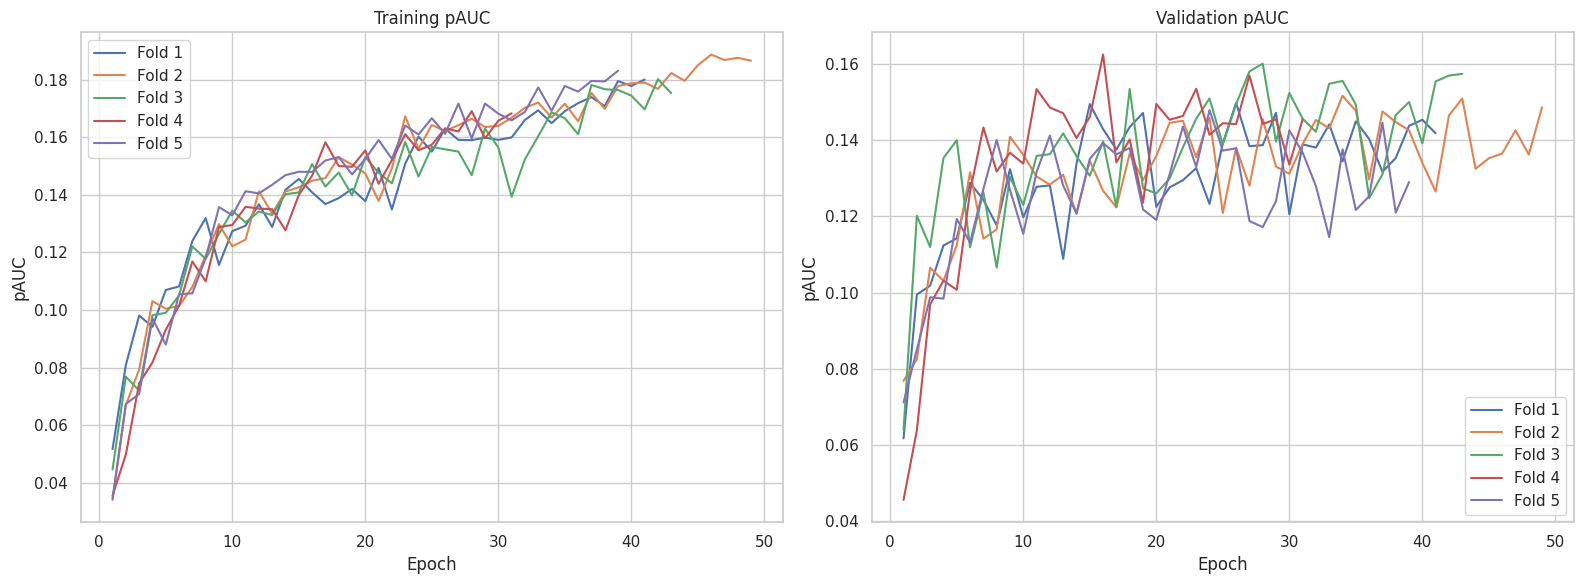

In [15]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='epoch', y='train_pauc', hue='Fold', data=histories, ax=axes[0])
axes[0].set_title('Training pAUC')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('pAUC')
axes[0].legend(loc='best')

sns.lineplot(x='epoch', y='val_pauc', hue='Fold', data=histories, ax=axes[1])
axes[1].set_title('Validation pAUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('pAUC')
axes[1].legend(loc='best')

fig.tight_layout()
plt.show()

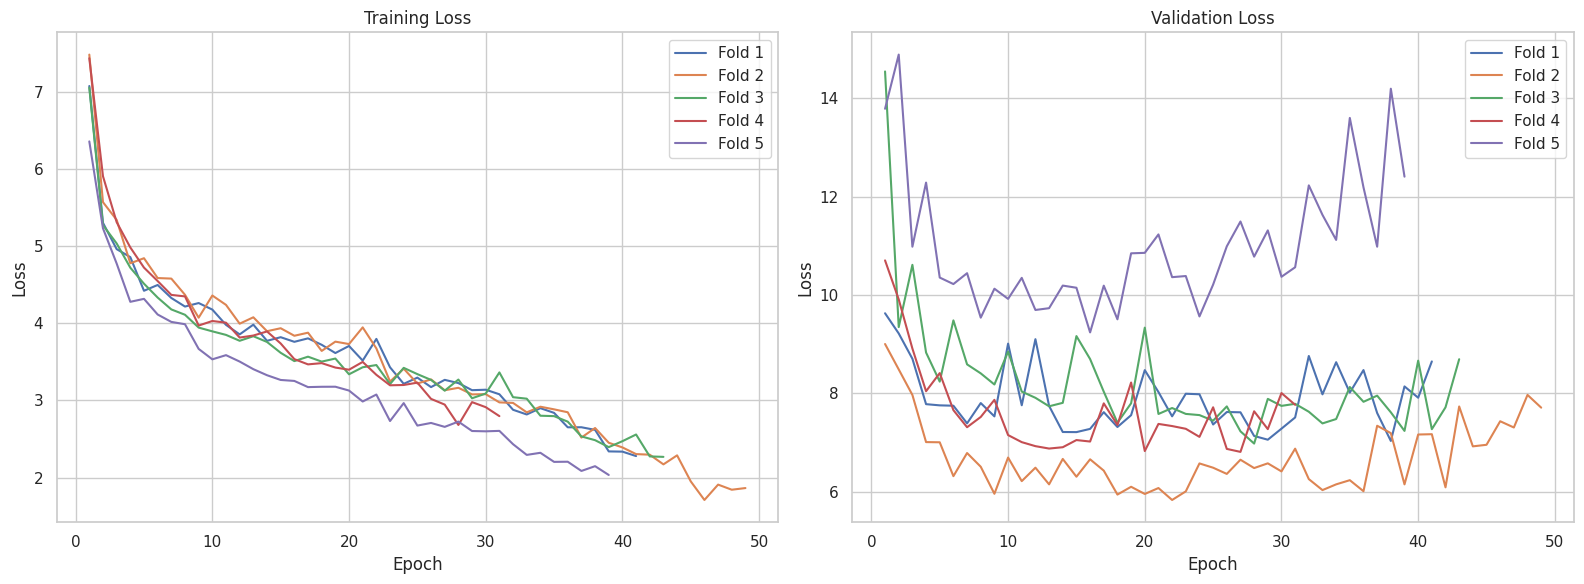

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='epoch', y='train_loss', hue='Fold', data=histories, ax=axes[0])
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='best')

sns.lineplot(x='epoch', y='val_loss', hue='Fold', data=histories, ax=axes[1])
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='best')

fig.tight_layout()
plt.show()